### Necessary imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

import RNA
import Bio

import tempfile
from IPython.display import SVG, HTML, display
from typing import List, Set, Union

### Utility functions

In [2]:
def standardize_sequence(x:str) -> str:
    ''' Setting all caracters to upper case and converting T to U '''
    string = x.upper()
    string = string.replace('T', 'U')
    return string

def pairs2db(seq_lenth:int, pairs:Set[tuple]) -> str:
    ''' Get dot bracket string from pairs '''
    dbstring = ['.'] * seq_lenth
    for pair in pairs:
        a, b = pair
        if a > b:
            a, b = b, a
        dbstring[a] = '('
        dbstring[b] = ')'
    return ''.join(dbstring)

def db2pairs(dbstring:str) -> Set[tuple]:
    ''' Parse dot bracket string to pairs '''
    pairs = set()
    stack = []
    for i in range(len(dbstring)):
        if dbstring[i] == '(':
            stack.append(i)
        elif dbstring[i] == ')':
            if len(stack) == 0:
                raise ValueError("Unbalanced brackets")
            else: 
                pairs.add((stack.pop(),i))    
    if len(stack) != 0:
        raise ValueError("Unbalanced brackets")
    return pairs

def is_canonical_basepair(x:str, y:str) -> bool:
    ''' Check if pair is canonical '''
    if x == 'A' and y == 'U':
        return True
    elif x == 'U' and y == 'A':
        return True
    elif x == 'G' and y == 'C':
        return True
    elif x == 'C' and y == 'G':
        return True
    elif x == 'G' and y == 'U':
        return True
    elif x == 'U' and y == 'G':
        return True
    else:
        return False

def is_canonical(seq:str, dbstring:str) -> bool:
    ''' Check if a structure is canonical '''
    pairs = db2pairs(dbstring)
    for pair in pairs:
        if not is_canonical_basepair(seq[pair[0]-1], seq[pair[1]-1]):
            return False
    return True

In [3]:
from Bio import AlignIO

def read_file(filename, filetype=None, verbose=False):
    if filetype is None:
        if filename.split('.')[-1] == 'aln':
            filetype = 'clustal'
        elif filename.split('.')[-1] == 'stk':  
            filetype = 'stockholm'
        else:
            raise ValueError("File type not recognized")
    align = AlignIO.read(filename, filetype)
    if verbose: 
        print(f"filetype: {filetype}")
        print(align)
    return align

In [4]:
# test
alignment = read_file('data/Testdata/tRNA_7.stk', verbose=True)

print(alignment[0].seq)
print()

alignment_list = [str(record.seq) for record in alignment]
print(alignment_list)

filetype: stockholm
Alignment with 7 rows and 85 columns
GCAGUCGUGGCCGAGU---GGUUAAGGCGUCUGACUCGAAAUCA...GCG AC021639.5_181586-181505
GCGGGGGUGCCCGAGCCUGGCCAAAGGGGUCGGGCUCAGGACCC...GCA AP000063.1_59179-59095
UGGAGUAUAGCCAAG--UGG--UAAGGCAUCGGUUUUUGGUACC...CAG AP000397.1_114390-114319
CGGAAAGUAGCUUAGCUUGG--UAGAGCACUCGGUUUGGGACCG...CGA X03715.1_388-461
GCCGGGGUGGGGUAGUGGCCAUCCUGG---GGGACUGUGGAUCC...GCC U67517.1_7511-7582
GUAAACAUAGUUUA------AUCAAAACAUUAGAUUGUGAAUCU...ACC X99256.1_11558-11626
AGUAAAGUCAGCUA------AAAAAGCUUUUGGGCCCAUACCCC...CUA M10217.1_5910-5978
GCAGUCGUGGCCGAGU---GGUUAAGGCGUCUGACUCGAAAUCAGAUUCCCUCUGGGAGCGUAGGUUCGAAUCCUACCGGCUGCG

['GCAGUCGUGGCCGAGU---GGUUAAGGCGUCUGACUCGAAAUCAGAUUCCCUCUGGGAGCGUAGGUUCGAAUCCUACCGGCUGCG', 'GCGGGGGUGCCCGAGCCUGGCCAAAGGGGUCGGGCUCAGGACCCGAUGGCGUAGGCCUGCGUGGGUUCAAAUCCCACCCCCCGCA', 'UGGAGUAUAGCCAAG--UGG--UAAGGCAUCGGUUUUUGGUACCG---------GCAUGCAAAGGUUCGAAUCCUUUUACUCCAG', 'CGGAAAGUAGCUUAGCUUGG--UAGAGCACUCGGUUUGGGACCGA---------GGGGUCGCAGGUUCGAAUCCUGUCUUU

### RnaMolecule class
A class for molecules that contains the sequence and the according structrure

In [5]:
class RnaMolecule:
    ''' Class to represent RNA molecule with sequence and structure

    Properties
    ----------
    sequence: str
        sequence of the molecule
    dbstring: str
        dot bracket string of the structure
    pairs: set
        set of pairs of the structure
    '''
    def __init__(self, sequence, structure=None):
        """
        Initialises an instance

        Args:
            sequence: str, sequence of the molecule
            structure: dbstring or set of pairs of the structure, optionnal
        """
        self.sequence = standardize_sequence(sequence)
        if structure is None:
            self.dbstring = '.' * len(sequence)
            self.pairs = set()
        elif type(structure) == str:
            self.dbstring = structure
            self.pairs = db2pairs(structure)
        elif type(structure) == set:   
            self.pairs = structure
            self.dbstring = pairs2db(len(sequence), structure)
    
    def __str__(self):
        return f"RnaMolecule({self.sequence}, {self.dbstring})"

    def plot(self):
        fp = tempfile.NamedTemporaryFile(suffix="svg")
        RNA.svg_rna_plot(self.sequence, structure=self.dbstring, ssfile=fp.name)
        display(SVG(fp.name))

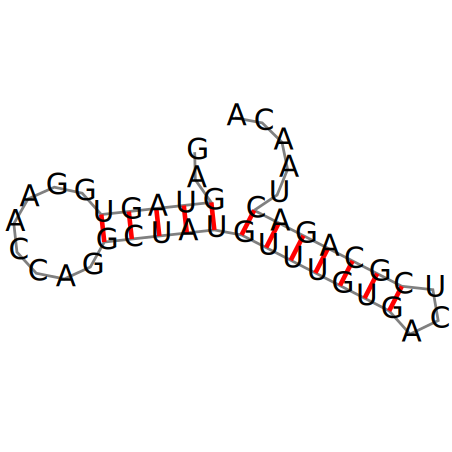

In [6]:
# test
sequence = "GAGUAGUGGAACCAGGCUAUGUUUGUGACUCGCAGACUAACA"
structure = "..(((((........)))))(((((((...)))))))....."

mol = RnaMolecule(sequence, structure)
mol.plot()

# Computing structure of a single sequence

### Using Nussinov algorithm

In [7]:
def compute_Nussinov_matrix(seq:str, min_loop=1) -> np.array:
    '''Predict folding of RNA sequence using Nussinov algorithm'''

    M = np.zeros((len(seq), len(seq)))
    for m in range(min_loop, len(seq)):
        for i in range(0, len(seq)-m):
            j = i + m
            M[i][j] = max([M[i,k] + M[k+1,j] for k in range(i, j)])
            if is_canonical_basepair(seq[i], seq[j]):
                M[i][j] = max(M[i][j], M[i+1,j-1] + 1)
    return M

def traceback_Nussinov(seq:str, M:np.array, min_loop:int) -> list:
    '''Traceback the Nussinov matrix to find the pairs'''
    
    def traceback_position(i,j):
        pairs = []
        while j-i >= min_loop:
            if is_canonical_basepair(seq[i], seq[j]) and M[i][j] == M[i+1][j-1] + 1:
                pairs.append((i,j))
                i += 1
                j -= 1
            elif M[i][j] == M[i+1][j]:  # not necessary, but avoids some recurisve calls
                i += 1
            elif M[i][j] == M[i][j-1]:
                j -= 1
            else:
                for k in range(i, j):
                    if M[i][j] == M[i][k] + M[k+1][j]:
                        pairs += traceback_position(i, k)
                        pairs += traceback_position(k+1, j)
                        return pairs
        return pairs

    return traceback_position(0, len(seq)-1)

def predict_structure_Nussinov(seq:str, min_loop=1) -> str:
    M = compute_Nussinov_matrix(seq, min_loop)
    pairs = traceback_Nussinov(seq, M, min_loop)
    return pairs2db(len(seq), pairs)

### Using MFE from Vienna package

In [8]:
def create_folding_compound(seq:str) -> RNA.fold_compound:
    '''Create a folding compound object from a sequence or a list of sequences'''
    md = RNA.md()   # create model details    
    md.uniq_ML = 1  # activate unique multibranch loop decomposition    
    fc = RNA.fold_compound(seq, md) # create fold compound object
    ss, mfe = fc.mfe()    # compute MFE
    fc.exp_params_rescale(mfe)  # rescale Boltzmann factors according to MFE; rescaling avoids numerical problems for long sequences
    fc.pf()    # compute partition function to fill DP matrices
    return fc

def predict_structure_mfe(fc:Union[str, RNA.fold_compound]) -> str:
    '''Predict folding of RNA sequence using Vienna package'''
    if type(fc) == str or type(fc) == list:
        fc = create_folding_compound(fc)
    ss, mfe = fc.mfe()
    return ss

def plot_base_pair_probabiliy(fc:Union[str, RNA.fold_compound]):
    '''Plots probability for two bases to be paired'''
    if type(fc) == str or type(fc) == list:
        fc = create_folding_compound(fc)
    bpp = fc.bpp()  # compute base pair probabilities
    bpp2 = [[math.sqrt(p)  for p in row[1:]]for row in bpp[1:]]
    plt.imshow(bpp2)

def plot_unpaired_probability(fc:Union[str, RNA.fold_compound]):
    '''Plots probability for a base to be unpaired'''
    if type(fc) == str or type(fc) == list:
        fc = create_folding_compound(fc)
    bpp = fc.bpp()  # compute base pair probabilities
    unp = [1-sum(bpp[i][j] + bpp[j][i] for j in range(1,len(sequence)+1)) for i in range(1,len(sequence)+1)]
    plt.plot(unp)
# TODO: check why sqrt in one function but not other ?

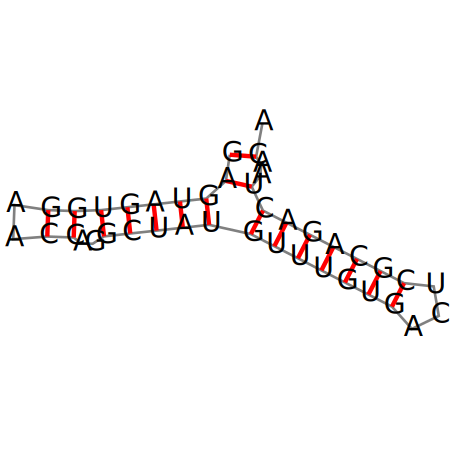

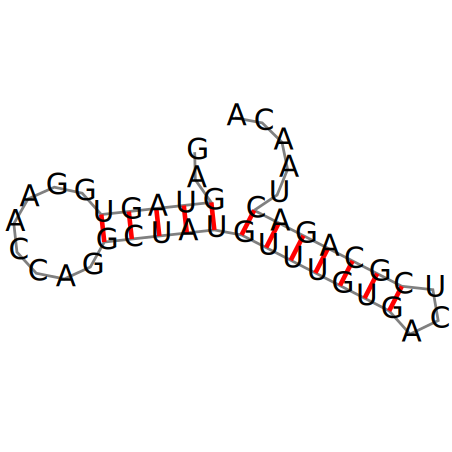

In [9]:
# test
sequence = "GAGUAGUGGAACCAGGCUAUGUUUGUGACUCGCAGACUAACA"
structure = "..(((((........)))))(((((((...)))))))....."

db = predict_structure_Nussinov(sequence,3)
mol = RnaMolecule(sequence, db)
mol.plot()

db2 = predict_structure_mfe(sequence)
mol2 = RnaMolecule(sequence, db2)
mol2.plot()

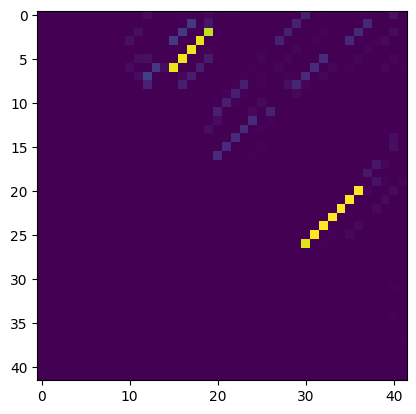

In [10]:
fc = create_folding_compound(sequence)
plot_base_pair_probabiliy(fc)

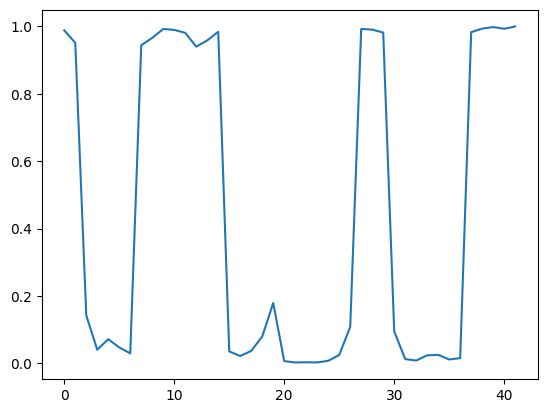

In [11]:
plot_unpaired_probability(fc)

# Computing structure for an alignement

### Using MTA: Maximum total accuracy

In [12]:
def unpaired_accuracy(sequences:List[str], dbstrings:List[str], i:int)->float:
    '''Compute the unpaired accuracy of a structure'''
    unpaired = 0
    for k in range(len(sequences)):
        if dbstrings[k][i] == '.':
            unpaired += 1
    return unpaired

def paired_accuracy(sequences:List[str], pairs:List[Set[tuple]], i:int, j:int)->float:
    '''Compute the paired accuracy of a structure'''
    paired = 0
    for k in range(len(sequences)):
        if (i,j) in pairs[k] or (j,i) in pairs[k]:
            paired += 1
    return 2*paired   # TODO: add lambda product

def compute_MFA_matrix(sequences:List[str], dbstrings:List[str], min_loop=1)->np.array:
    '''Predict folding of RNA alignement using modified Nussinov algorithm'''
    n = len(sequences[0])
    M = np.zeros((n, n))
    dbpairs = [db2pairs(db) for db in dbstrings]
    
    # initialize the matrix
    for m in range(0, min_loop):
        for i in range(0, n-m):
            j = i + m
            M[i][j] = unpaired_accuracy(sequences, dbstrings, i)
    # fill the matrix
    for m in range(min_loop, n):
        for i in range(0, n-m):
            j = i + m
            M[i][j] = max([M[i,k] + M[k+1,j] for k in range(i, j)])
            M[i][j] = max(M[i][j], M[i+1,j-1] + paired_accuracy(sequences, dbpairs, i, j))
    return M


def traceback_MFA(sequences:List[str], dbstrings:List[str], M:np.array, min_loop:int) -> list:
    '''Traceback the modified Nussinov matrix to find the pairs'''

    dbpairs = [db2pairs(db) for db in dbstrings]   
     
    def traceback_MFA_position(i,j):
        pairs = []
        while j-i >= min_loop:
            if M[i][j] == M[i+1][j-1] + paired_accuracy(sequences, dbpairs, i, j):
                pairs.append((i,j))
                i += 1
                j -= 1
            elif M[i][j] == M[i+1][j]:  # not necessary, but avoids some recurisve calls
                i += 1
            elif M[i][j] == M[i][j-1]:
                j -= 1
            else:
                for k in range(i, j):
                    if M[i][j] == M[i][k] + M[k+1][j]:
                        pairs += traceback_MFA_position(i, k)
                        pairs += traceback_MFA_position(k+1, j)
                        return pairs
        return pairs

    return traceback_MFA_position(0, len(sequences[0])-1)

def predict_structure_MFA(sequences:List[str], dbstrings=None, min_loop=1)->str:
    if dbstrings is None:
        # use Vienna package to compute mfe structure independently for each sequence
        dbstrings = [predict_structure_mfe(seq) for seq in sequences]
    # use Nussinov algorithm to compute the structure of the alignment
    M = compute_MFA_matrix(sequences, dbstrings, min_loop)
    pairs = traceback_MFA(sequences, dbstrings, M, min_loop)
    return pairs2db(len(sequences[0]), pairs)

In [13]:
# test
seq = ["GC-C-AAA-GGC", "GGGC-AUU-GCC", "AC-GGAAUCCGU"]
db = ["((-(-...-)))", "((-(-...-)))", "((-((...))))"]
pairs = [db2pairs(x) for x in db]

db = predict_structure_MFA(seq, db, 1)
print(db)

((.((...))))


In [15]:
# test
alignment = read_file('data/Testdata/tRNA_7.stk')
alignment_list = [str(record.seq) for record in alignment]
dbstrings = [predict_structure_mfe(seq) for seq in alignment_list]

for seq in alignment_list:
    print(seq)
for db in dbstrings:
    print(db)
print()

ss = predict_structure_MFA(alignment_list, dbstrings)
print(ss)

ss2 = predict_structure_mfe(alignment_list) # mfe from Vienna also works directly for alignments
print(ss2)

GCAGUCGUGGCCGAGU---GGUUAAGGCGUCUGACUCGAAAUCAGAUUCCCUCUGGGAGCGUAGGUUCGAAUCCUACCGGCUGCG
GCGGGGGUGCCCGAGCCUGGCCAAAGGGGUCGGGCUCAGGACCCGAUGGCGUAGGCCUGCGUGGGUUCAAAUCCCACCCCCCGCA
UGGAGUAUAGCCAAG--UGG--UAAGGCAUCGGUUUUUGGUACCG---------GCAUGCAAAGGUUCGAAUCCUUUUACUCCAG
CGGAAAGUAGCUUAGCUUGG--UAGAGCACUCGGUUUGGGACCGA---------GGGGUCGCAGGUUCGAAUCCUGUCUUUCCGA
GCCGGGGUGGGGUAGUGGCCAUCCUGG---GGGACUGUGGAUCCC----------CUGACCCGGGUUCAAUUCCCGGUCCCGGCC
GUAAACAUAGUUUA------AUCAAAACAUUAGAUUGUGAAUCUAA----------CAAUAGAGGCUCGAAACCUCUUGCUUACC
AGUAAAGUCAGCUA------AAAAAGCUUUUGGGCCCAUACCCCAA----------ACAUGUUGGUUAAACCCCUUCCUUUACUA
(((((((..(((.............)))((((((.......))))))((((...))))..(((((.......)))))))))))).
(((((((..((.((((((((((.....)))))))))).)).......(((....)))...(((((.......)))))))))))).
(((((((...(((....)))......((((((((.......))))...........))))(((((.......)))))))))))).
((((((((((....((((......))))..((((.(((.((((.............)))).)))..))))...))).))))))).
.(((((((((........)))))))))...((((((((((((((..........

### Using MEA: Maximum expected accuracy
For this, we need the base pair probability guiven by the Vienna package with `fc.bpp()`.